In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras

import Rakuten_preprocessing as rkt
from importlib import reload 
reload(rkt)

from Rakuten_preprocessing import Rakuten_img_path

c:\ProgramData\anaconda3\envs\Rakuten\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

In [3]:
folder_path = '../data/clean/'
data = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
target = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
prdtype = pd.read_csv('../data/prdtype.csv', index_col='prdtypecode')
target = prdtype.loc[target['prdtypecode'], 'prdtypedesignation']

In [3]:
data.head()

,designation,description,productid,imageid,language,designation_translated,description_translated
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,de,Olivia : Carnet personnalisé / 150 pages / gri...,NaN
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,fr,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,fr,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,en,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN
4,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...,278535884,1077757786,fr,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...


## Tokenize translated text

In [4]:
#tokenize multiple columns
from nltk.tokenize import word_tokenize

colnames = ['designation', 'description']#['designation_translated', 'description_translated'] #
merged_txt = data[colnames].apply(lambda row: ' '.join(s for s in row if isinstance(s, str)), axis=1)
data['tokens'] = merged_txt.str.lower().apply(lambda x: word_tokenize(x, language='french'))

## Remove stopwords and punctuation from tokens

In [5]:
def remove_wordsubset(words, wordsubset):
    #remove words in wordsubset
    words_filtered = [word for word in words if word not in wordsubset]
    return words_filtered

def remove_token_duplicates(words):
    #remove duplicated tokens, keeping the same order
    wordset = set()
    words_filtered = [wordset.add(word) or word for word in words if word not in wordset]
    return words_filtered

In [ ]:
#Removing stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, stop_words))

In [6]:
#Removing puntuation
punctuations = [",", ".", "``", "@", "*", "(", ")", "...", "!", "?", "-", "_", ">", "<", ":", "/", "=", "--", "©", "~", ";", "\\", "\\\\"]
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, punctuations))

In [ ]:
#Removing duplicated tokens
data['tokens'] = data['tokens'].apply(lambda x: remove_token_duplicates(x))

In [7]:
#Converting list of tokens to string
data['tokens'] = data['tokens'].apply(lambda x:  ' '.join(x))

## Further cleaning with Regex?

In [ ]:
#import re

#remove words shorter than 4 characters
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b\w{1,2}\b(?!°)", ' ', x))

#remove numbers
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"[0-9]+", ' ', x))

#remove any word that has no vowel
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b(?![^aeiouyáéíóúàèìòùâêîôûäëïöü])[^\s]+\b", ' ', x))

#removing extra spaces
#data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x.split()))

## Function to plot results

In [8]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = round(pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100)

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,12), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

## Dataframe for MultiModal generator

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Encoding classes as integers
encoder = LabelEncoder()
labels = encoder.fit_transform(target)

img_paths = Rakuten_img_path(img_folder=r"C:\Users\Julien Fournier\Documents\DST\RakutenProject\Data\images\image_train_resized",
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')

df = pd.DataFrame({'labels': labels, 'img_path': img_paths, 'text': data['tokens']})

## Creating train and test sets

In [116]:
from sklearn.model_selection import train_test_split

#Creating train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123, stratify=labels)

## Image generator

In [117]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

#Data generator for the train and test sets
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                          horizontal_flip=True, fill_mode='constant', cval=255)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, fill_mode='constant', cval=255)

# train_generator = train_data_generator.flow_from_dataframe(dataframe=df_train, x_col='img_path', y_col='labels',
#                                                            class_mode='raw', target_size=(224, 224),
#                                                            batch_size=64)

# test_generator = test_data_generator.flow_from_dataframe(dataframe=df_train, x_col='img_path', y_col='labels',
#                                                            class_mode='raw', shuffle=False, target_size=(224, 224),
#                                                            batch_size=64)

## Custom Generator

In [118]:
from keras.utils import Sequence

class MultimodalDataGenerator(Sequence):
    def __init__(self, img_data_generator, dataframe, text_column, batch_size, img_dir, x_col="filename", y_col="class", target_size = (224, 224), shuffle=True):
        self.img_data_generator = img_data_generator
        self.dataframe = dataframe.rename(columns={x_col: 'filename'})#dataframe.copy()
        self.text_column = text_column
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.x_col = x_col
        self.y_col = y_col
        self.target_size = target_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:min((index + 1) * self.batch_size, len(self.dataframe))]
        batch_df = self.dataframe.iloc[batch_indexes]
        
        img_generator = self.img_data_generator.flow_from_dataframe(dataframe=batch_df, directory=self.img_dir, target_size=self.target_size,
                                                                    x_col="filename", y_col=None,class_mode=None,
                                                                    batch_size=len(batch_df), shuffle=False)
        
        images = np.concatenate([img_generator.next() for _ in range(len(img_generator))], axis=0)
        
        texts = batch_df[self.text_column].values
        labels = batch_df[self.y_col].values
        
        return [images, texts], labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [122]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

img_size = (500, 500, 3)

#Data generator for the train and test sets
train_img_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                          horizontal_flip=True, fill_mode='constant', cval=255)

test_img_generator = ImageDataGenerator(preprocessing_function=preprocess_input, fill_mode='constant', cval=255)


train_multi_generator = MultimodalDataGenerator(img_data_generator=train_img_generator,img_dir='path/to/your/images', dataframe=df_train,
                                                 text_column='text',x_col='img_path',y_col='labels',
                                                 batch_size=64, shuffle=True, target_size=img_size[0:2])

test_multi_generator = MultimodalDataGenerator(img_data_generator=test_img_generator,img_dir='path/to/your/images', dataframe=df_test,
                                                 text_column='text',x_col='img_path',y_col='labels',
                                                 batch_size=64, shuffle=False, target_size=img_size[0:2])

In [123]:
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from keras.layers import Input, TextVectorization, Embedding, Flatten, Dense, Conv1D, Conv2D, Dropout, MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.models import Sequential, Model
from keras.layers import LSTM, GRU
from keras.metrics import F1Score
from keras import regularizers
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D

num_class = len(np.unique(labels))

#imagenet with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False)
#freezing ResNet50 weights
for layer in base_model.layers:
    layer.trainable = False
    
input_img = Input(shape=img_size)
x = base_model(input_img)
x = GlobalAveragePooling2D()(x)#Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=128, activation='relu')(x)
model_resnet = Model(inputs=input_img, outputs=x)

In [124]:
#Size of vocabulary
max_len = 600 #max length of senetnces in tokens
max_tok = 140000 #max number of different tokens
outvec_size = 300
n_class = len(np.unique(labels)) #number of classes for classification layer
f1_score = F1Score(average='weighted', threshold=None, name='f1_score', dtype=None) #Can't yet make that one work

#Building simple dense model with embedding
input_txt = Input(shape=(1,), dtype=tf.string)
x = TextVectorization(max_tokens=max_tok, output_mode='int', output_sequence_length=max_len, standardize="lower_and_strip_punctuation", split='whitespace')(input_txt)
x = Embedding(input_dim=max_tok, output_dim=outvec_size, input_length=max_len)(x)
x = Dropout(rate=0.5)(x)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)

model_txt = Model(inputs=input_txt, outputs=x)

#Creating the vocabulary for the tokenizer before training
model_txt.layers[1].adapt(df_train['text'])

In [125]:
from keras.layers import Concatenate

#Concatenate text and image models
concatenated = Concatenate()([model_resnet.output, model_txt.output])

#Dense layers for classification
x = Dropout(rate=0.5)(x)
x = Dense(units=128, activation='relu')(concatenated)
outputs = Dense(units=num_class, activation='softmax')(x)

model_merged = Model(inputs=[model_resnet.input, model_txt.input], outputs=outputs)
model_merged.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_merged.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_34 (InputLayer)       [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 text_vectorization_10 (Tex  (None, 600)                  0         ['input_35[0][0]']            
 tVectorization)                                                                                  
                                                                                                  
 resnet50 (Functional)       (None, None, None, 2048)     2358771   ['input_34[0][0]']     

In [126]:
history = model_merged.fit(x=train_multi_generator, validation_data=test_multi_generator, epochs=4)

Found 64 validated image filenames.


Epoch 1/4
Found 64 validated image filenames.
Found 64 validated image filenames.
1062/1062 [==============================] - ETA: 0s - loss: 1.1418 - accuracy: 0.6650Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Found 64 validated image filenames.
Foun

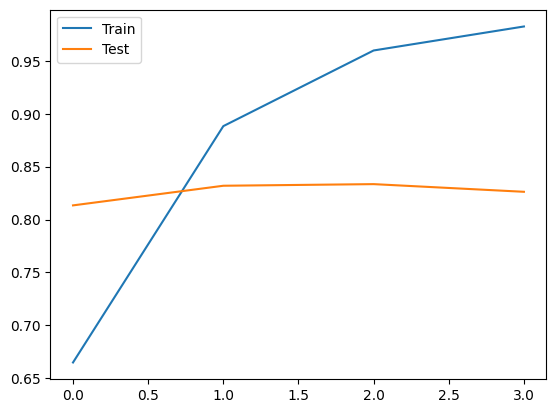

In [127]:
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history['accuracy'], label='Train')
plt.plot(history.epoch, history.history['val_accuracy'], label='Test')

plt.legend()
plt.show()

In [96]:
test_pred = model_merged.predict(test_multi_generator)
test_pred_class = np.argmax(test_pred, axis=1)


Found 64 validated image filenames.


Found 64 validated image filenames.
Found 64 validated image filenames.
  1/265 [..............................] - ETA: 8:33Found 64 validated image filenames.
Found 64 validated image filenames.
  6/265 [..............................] - ETA: 2:02Found 64 validated image filenames.
Found 64 validated image filenames.
  9/265 [>.............................] - ETA: 2:02Found 64 validated image filenames.
Found 64 validated image filenames.
 12/265 [>.............................] - ETA: 2:00Found 64 validated image filenames.
Found 64 validated image filenames.
 24/265 [=>............................] - ETA: 1:54Found 64 validated image filenames.
Found 64 validated image filenames.
 31/265 [==>...........................] - ETA: 1:50Found 64 validated image filenames.
Found 64 validated image filenames.
 39/265 [===>..........................] - ETA: 1:47Found 64 validated image filenames.
Found 64 validated image filenames.
 41/265 [===>..........................] - ETA: 1:46Found 64

ValueError: Found input variables with inconsistent numbers of samples: [16984, 16960]

In [98]:
df_test['labels'].shape

(16984,)

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       336
           1       0.82      0.82      0.82       165
           2       0.87      0.99      0.93       790
           3       0.91      0.86      0.88       160
           4       0.93      0.85      0.89       166
           5       0.57      0.63      0.60       153
           6       0.78      0.82      0.80       534
           7       0.95      0.93      0.94       997
           8       0.61      0.52      0.56       411
           9       0.82      0.93      0.87      1007
          10       0.74      0.83      0.79       502
          11       0.77      0.83      0.80       284
          12       1.00      0.99      1.00       173
          13       0.69      0.58      0.63       972
          14       0.90      0.87      0.89       860
          15       0.85      0.80      0.82       955
          16       0.92      0.76      0.83       552
          17       0.60    

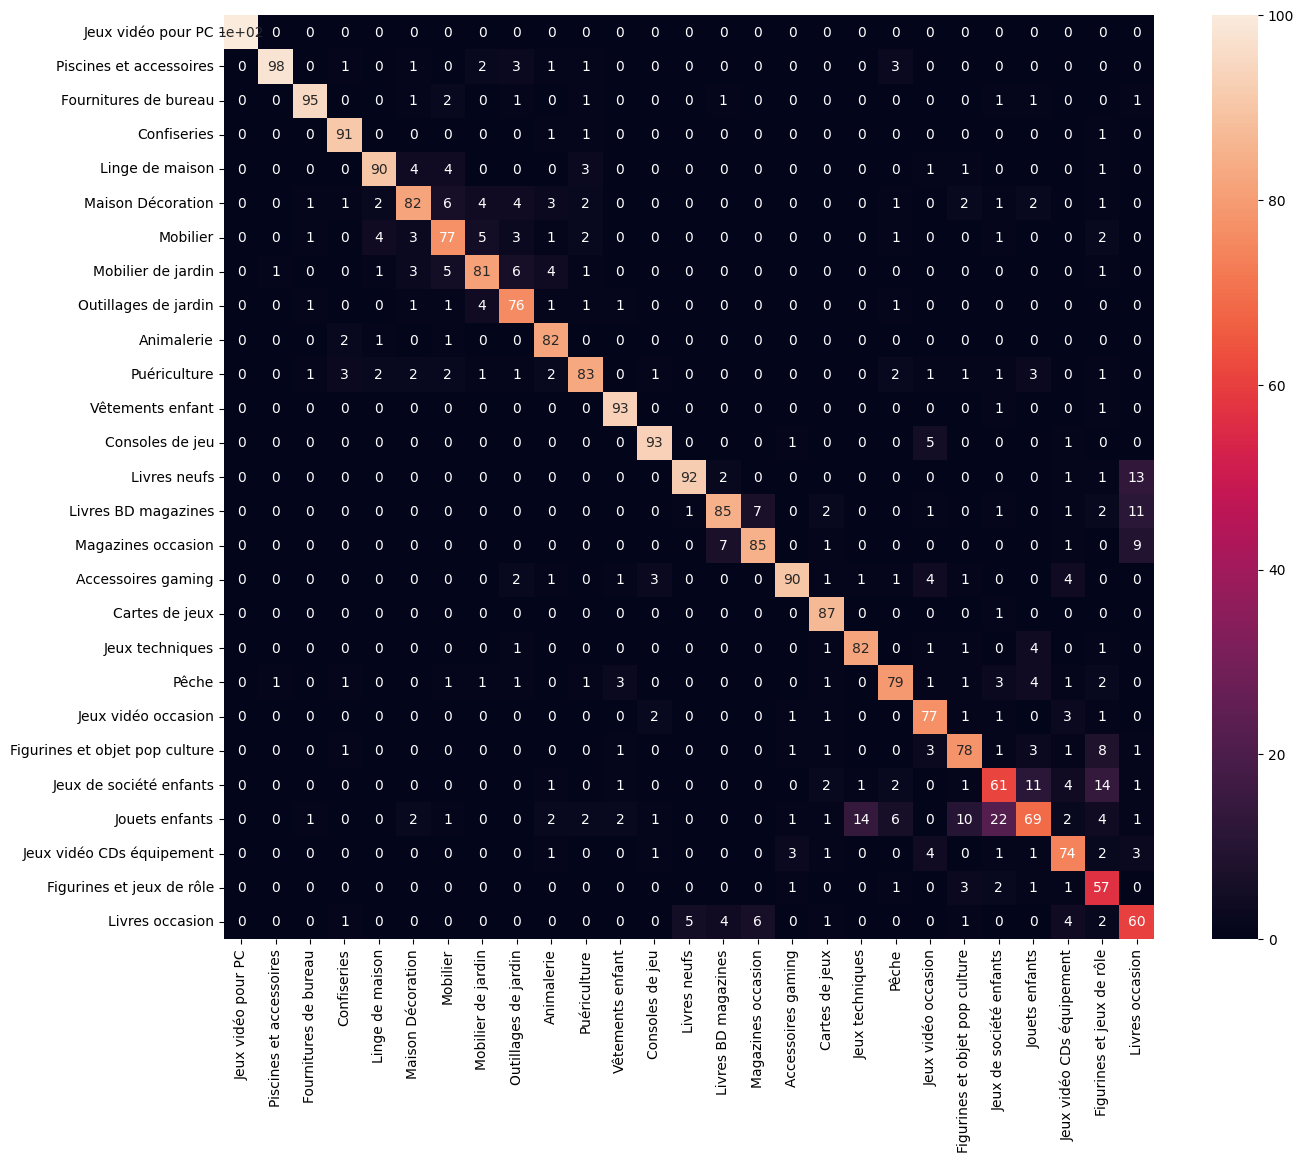

<module 'matplotlib.pyplot' from 'c:\\ProgramData\\anaconda3\\envs\\Rakuten\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [100]:

plot_classification_results(df_test['labels'].iloc[:test_pred_class.shape[0]], test_pred_class, index=encoder.classes_)

In [101]:
from sklearn.metrics import f1_score

f1_score(df_test['labels'].iloc[:test_pred_class.shape[0]], test_pred_class, average='weighted')

0.829730915892058